In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Respuesta al impulso:

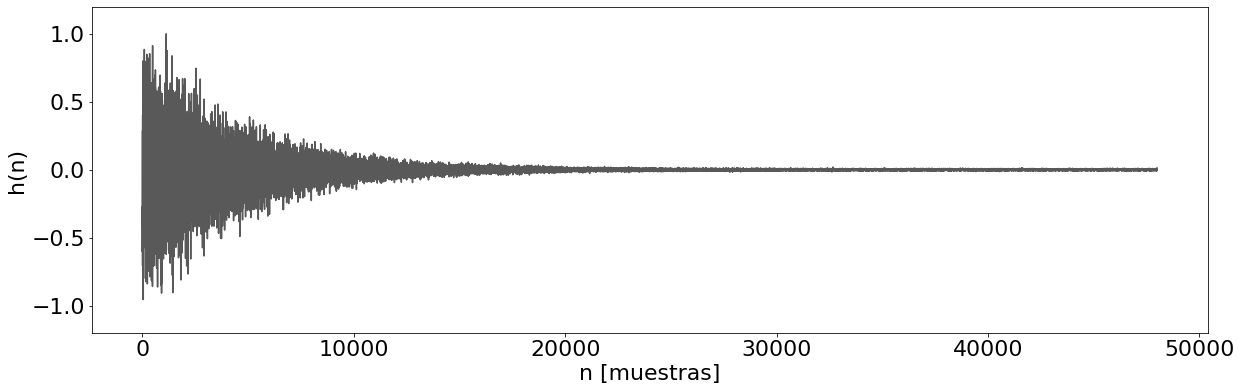

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import matplotlib

def syntheticRIR(Rt, fs):
  # Reconstruir una RIR con el método de schroeder a partir de conocer el tiempo de reverberación

  t = np.arange(0, int(Rt+1), 1/fs)
  a = 1 #Amplitud de la RIR

  y = a*np.e**((-6.9*t)/Rt) # Creo una exponencial decreciente

  seed = randrange(int(2**32))
  
  np.random.seed(seed)
  n = np.random.normal(0, 1, y.shape) #Genero ruido blanco

  y = y*n + n*0.01#Multiplico el ruido por la señal

  return y/max(y), seed

rir, _ = syntheticRIR(2, 16000)


#plt.style.use('grayscale')
plt.figure(facecolor='white', figsize=[20,6], )
plt.plot(rir, color='0.35')
plt.ylabel('h(n)')
plt.xlabel('n [muestras]')
plt.ylim(-1.2,1.2)
matplotlib.rcParams.update({'font.size': 22})

plt.show()

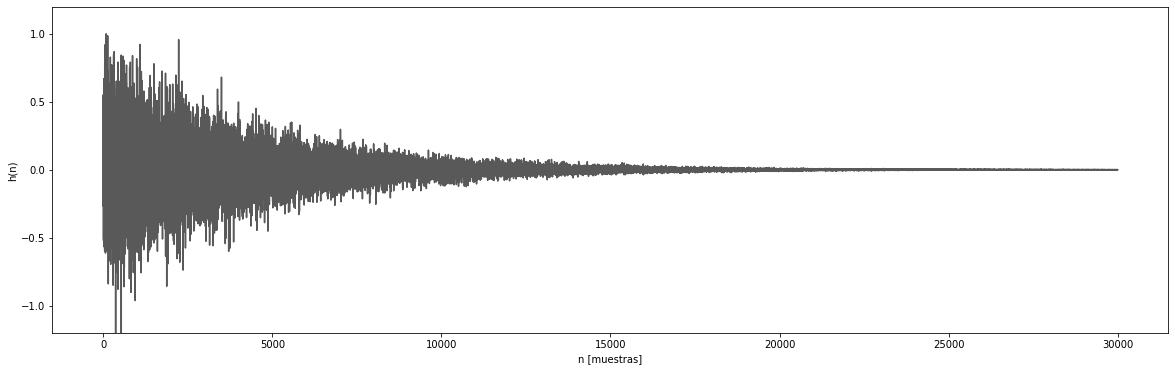

In [ ]:
# Recorto la rir:
rir = rir[:30000]

plt.figure(facecolor='white', figsize=[20,6], )
plt.plot(rir, color='0.35')
plt.ylabel('h(n)')
plt.xlabel('n [muestras]')
plt.ylim(-1.2,1.2)
matplotlib.rcParams.update({'font.size': 22})

plt.show()

In [ ]:
# Librerías que voy a usar:
!pip install stats
import numpy as np
import librosa
from scipy.signal import butter, sosfilt, lfilter, fftconvolve, hilbert
import scipy as sp
from random import randrange
import stats
import math
import sys


# Cálculo del TR:
def leastsquares(x, y):
    """Given two vectors x and y of equal dimension, calculates
    the slope and y intercept of the y2 = c + m*x slope, obtained
    by least squares linear regression
    Documentation for numpy function used:
    https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.linalg.lstsq.html
    Output arguments
    c = y-intercept
    m = slope
    y2 = least square line"""

    # Rewriting the line equation as y = Ap, where A = [[x 1]]
    # and p = [[m], [c]]
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=-1)[0]  # Finding coefficients m and c
    y2 = m*x+c  # Fitted line
    return m, c, y2

def lundeby(y, Fs, Ts):
    """Given IR response "y" and samplerate "Fs" function returns upper integration limit of
    Schroeder's integral. Window length in ms "Ts" indicates window sized of the initial averaging of the input signal,
    Luneby recommends this value to be in the 10 - 50 ms range."""

    y_power = y
    y_promedio = np.zeros(int(len(y) / Fs / Ts))
    eje_tiempo = np.zeros(int(len(y) / Fs / Ts))

    t = math.floor(len(y_power) / Fs / Ts)
    v = math.floor(len(y_power) / t)

    for i in range(0, t):
        y_promedio[i] = sum(y_power[i * v:(i + 1) * v]) / v
        eje_tiempo[i] = math.ceil(v / 2) + (i * v)

    # First estimate of the noise level determined from the energy present in the last 10% of input signal
    ruido_dB = 10 * np.log10(
        sum(y_power[round(0.9 * len(y_power)):len(y_power)]) / (0.1 * len(y_power)) / max(y_power))
    y_promediodB = 10 * np.log10(y_promedio / max(y_power))

    # Decay slope is estimated from a linear regression between the time interval that contains the maximum of the
    # input signal (0 dB) and the first interval 10 dB above the initial noise level
    r = int(max(np.argwhere(y_promediodB > ruido_dB + 10)))
    m, c, rectacuadmin = leastsquares(eje_tiempo[0:r], y_promediodB[0:r])
    cruce = (ruido_dB - c) / m

    if ruido_dB > -20:  # Insufficient S/N ratio to perform Lundeby
        punto = len(y_power)
        C = None
    else:

        # Begin Luneby's iterations
        error = 1
        INTMAX = 25
        veces = 1
        while error > 0.0001 and veces <= INTMAX:

            # Calculates new time intervals for median, with aprox. p-steps per 10 dB
            p = 10  # Number of steps every 10 dB
            delta = abs(10 / m)  # Number of samples for the 10 dB decay slope
            v = math.floor(delta / p)  # Median calculation window
            if (cruce - delta) > len(y_power):
                t = math.floor(len(y_power) / v)
            else:
                t = math.floor(len(y_power[0:round(cruce - delta)]) / v)
            if t < 2:
                t = 2

            media = np.zeros(t)
            eje_tiempo = np.zeros(t)
            for i in range(0, t):
                media[i] = sum(y_power[i * v:(i + 1) * v]) / len(y_power[i * v:(i + 1) * v])
                eje_tiempo[i] = math.ceil(v / 2) + (i * v)
            mediadB = 10 * np.log10(media / max(y_power))
            m, c, rectacuadmin = leastsquares(eje_tiempo, mediadB)

            # New median of the noise energy calculated, starting from the point of the decay line 10 dB under the cross-point
            noise = y_power[(round(abs(cruce + delta))):]
            if len(noise) < round(0.1 * len(y_power)):
                noise = y_power[round(0.9 * len(y_power)):]
            rms_dB = 10 * np.log10(sum(noise) / len(noise) / max(y_power))

            # New cross-point
            error = abs(cruce - (rms_dB - c) / m) / cruce
            cruce = round((rms_dB - c) / m)
            veces += 1
    # output
    if cruce > len(y_power):
        punto = len(y_power)
    else:
        punto = cruce
    C = max(y_power) * 10 ** (c / 10) * math.exp(m / 10 / np.log10(math.exp(1)) * cruce) / (
                -m / 10 / np.log10(math.exp(1)))
    return punto, C

def schroeder(ir, t, C):
    """ Smooths a curve (ir) using Schroeder Integration method. "t" and "C" are Lundeby's compensation arguments """
    ir = ir[0:int(t)]
    y = np.flip((np.cumsum(np.flip(ir)) + C) / (np.sum(ir) + C))
    return y
  
def TR(y, fs):
  """TR calculates T20, T30 and EDT parameters given a smoothed energy response "y" and its samplerate "fs" """
  #Normalizo y obtengo el cuadrado de la señal
  y = y / max(y)
  y **= 2
  
  #Recorto la señal desde el máximo en adelante:
  in_max = np.where(abs(y) == np.max(abs(y)))[0]  # Windows signal from its maximum onwards.
  in_max = int(in_max[0])
  y = y[(in_max):]

  y_plot = 20*np.log10(y / max(y))

  #Encuentro los cortes de lundeby:
  t, C = lundeby(y, fs, 0.05)
  
  #Saco schroeder:
  sch = schroeder(y, t, C)
  sch = 10 * np.log10(sch / max(sch) + sys.float_info.epsilon)
  sch_tot = sch

  if np.min(sch) > -10:
    #Cálculo de los TRs:
    t = np.arange(0, len(sch) / fs, 1 / fs)

    i_max = np.where(sch == max(sch))                               # Finds maximum of input vector
    sch = sch[int(i_max[0][0]):]
    
    iaux = np.where((sch <= max(sch) - 1) & (sch > (max(sch) - 2)))
    i_edt = list(range(int(iaux[0]), int(len(sch))))                    # Index of values between 0 and the end (Note: -1 to -10 dB interval used for calculations of EDT)
    
    iaux = np.where((sch <= max(sch) - 5) & (sch > (max(sch) - 6)))     # Notar que acá estoy suponiendo que por lo menos tendo de 0 a -6dB siempre!
    i_10 = list(range(int(iaux[0]), int(len(sch))))                     # Index of values between -5 and the end
    i_20 = list(range(int(iaux[0]), int(len(sch))))                     # Index of values between -5 and the end
    i_30 = list(range(int(iaux[0]), int(len(sch))))                     # Index of values between -5 and the end

    t_edt = t[i_edt]
    t_10 = t[i_10]
    t_20 = t[i_20]
    t_30 = t[i_30]

    y_edt = sch[i_edt]
    y_t10 = sch[i_10]
    y_t20 = sch[i_20]
    y_t30 = sch[i_30]

    m_edt, c_edt, f_edt = leastsquares(t_edt, y_edt)            #leastsquares function used to find slope intercept and line of each parameter
    m_t10, c_t10, f_t10 = leastsquares(t_10, y_t10)
    m_t20, c_t20, f_t20 = leastsquares(t_20, y_t20)
    m_t30, c_t30, f_t30 = leastsquares(t_30, y_t30)

    EDT = -60 / m_edt                                         # EDT, T20 and T30 calculations
    T10 = -60 / m_t10
    T20 = -60 / m_t20
    T30 = -60 / m_t30

    TRs = [EDT, T10, T20, T30]

  elif np.min(sch) > -15:
    #Cálculo de los TRs:
    t = np.arange(0, len(sch) / fs, 1 / fs)

    i_max = np.where(sch == max(sch))                               # Finds maximum of input vector
    sch = sch[int(i_max[0][0]):]
    i_edt = np.where((sch <= max(sch) - 1) & (sch > (max(sch) - 10)))   # Index of values between 0 and -10 dB (Note: -1 to -10 dB interval used for calculations of EDT)
    iaux = np.where((sch <= max(sch) - 5) & (sch > (max(sch) - 6)))     
    i_10 = list(range(int(iaux[0]), int(len(sch))))                     # Index of values between -5 and the end
    i_20 = list(range(int(iaux[0]), int(len(sch))))                     # Index of values between -5 and the end
    i_30 = list(range(int(iaux[0]), int(len(sch))))                     # Index of values between -5 and the end

    t_edt = t[i_edt]
    t_10 = t[i_10]
    t_20 = t[i_20]
    t_30 = t[i_30]

    y_edt = sch[i_edt]
    y_t10 = sch[i_10]
    y_t20 = sch[i_20]
    y_t30 = sch[i_30]

    m_edt, c_edt, f_edt = leastsquares(t_edt, y_edt)            #leastsquares function used to find slope intercept and line of each parameter
    m_t10, c_t10, f_t10 = leastsquares(t_10, y_t10)
    m_t20, c_t20, f_t20 = leastsquares(t_20, y_t20)
    m_t30, c_t30, f_t30 = leastsquares(t_30, y_t30)

    EDT = -60 / m_edt                                         # EDT, T20 and T30 calculations
    T10 = -60 / m_t10
    T20 = -60 / m_t20
    T30 = -60 / m_t30

    TRs = [EDT, T10, T20, T30]

  elif np.min(sch) > -25:
    #Cálculo de los TRs:
    t = np.arange(0, len(sch) / fs, 1 / fs)

    i_max = np.where(sch == max(sch))                               # Finds maximum of input vector
    sch = sch[int(i_max[0][0]):]
    i_edt = np.where((sch <= max(sch) - 1) & (sch > (max(sch) - 10)))   # Index of values between 0 and -10 dB (Note: -1 to -10 dB interval used for calculations of EDT)
    i_10 = np.where((sch <= max(sch) - 5) & (sch > (max(sch) - 15)))    # Index of values between -5 and -25 dB
    i_20 = list(range(int(i_10[0]), int(len(sch))))                     # Index of values between -5 and the end
    i_30 = list(range(int(i_10[0]), int(len(sch))))                     # Index of values between -5 and the end

    t_edt = t[i_edt]
    t_10 = t[i_10]
    t_20 = t[i_20]
    t_30 = t[i_30]

    y_edt = sch[i_edt]
    y_t10 = sch[i_10]
    y_t20 = sch[i_20]
    y_t30 = sch[i_30]

    m_edt, c_edt, f_edt = leastsquares(t_edt, y_edt)            #leastsquares function used to find slope intercept and line of each parameter
    m_t10, c_t10, f_t10 = leastsquares(t_10, y_t10)
    m_t20, c_t20, f_t20 = leastsquares(t_20, y_t20)
    m_t30, c_t30, f_t30 = leastsquares(t_30, y_t30)

    EDT = -60 / m_edt                                         # EDT, T20 and T30 calculations
    T10 = -60 / m_t10
    T20 = -60 / m_t20
    T30 = -60 / m_t30

    TRs = [EDT, T10, T20, T30]

  elif np.min(sch) > -35:
    #Cálculo de los TRs:
    t = np.arange(0, len(sch) / fs, 1 / fs)

    i_max = np.where(sch == max(sch))                               # Finds maximum of input vector
    sch = sch[int(i_max[0][0]):]
    i_edt = np.where((sch <= max(sch) - 1) & (sch > (max(sch) - 10)))   # Index of values between 0 and -10 dB (Note: -1 to -10 dB interval used for calculations of EDT)
    i_10 = np.where((sch <= max(sch) - 5) & (sch > (max(sch) - 15)))    # Index of values between -5 and -25 dB
    i_20 = np.where((sch <= max(sch) - 5) & (sch > (max(sch) - 25)))    # Index of values between -5 and -25 dB
    i_30 = list(range(int(i_20[0]), int(len(sch))))                     # Index of values between -5 and the end

    t_edt = t[i_edt]
    t_10 = t[i_10]
    t_20 = t[i_20]
    t_30 = t[i_30]

    y_edt = sch[i_edt]
    y_t10 = sch[i_10]
    y_t20 = sch[i_20]
    y_t30 = sch[i_30]

    m_edt, c_edt, f_edt = leastsquares(t_edt, y_edt)            #leastsquares function used to find slope intercept and line of each parameter
    m_t10, c_t10, f_t10 = leastsquares(t_10, y_t10)
    m_t20, c_t20, f_t20 = leastsquares(t_20, y_t20)
    m_t30, c_t30, f_t30 = leastsquares(t_30, y_t30)

    EDT = -60 / m_edt                                         # EDT, T20 and T30 calculations
    T10 = -60 / m_t10
    T20 = -60 / m_t20
    T30 = -60 / m_t30

    TRs = [EDT, T10, T20, T30]

  elif np.min(sch) <= -35:
    #Cálculo de los TRs:
    t = np.arange(0, len(sch) / fs, 1 / fs)

    i_max = np.where(sch == max(sch))                               # Finds maximum of input vector
    sch = sch[int(i_max[0][0]):]
    i_edt = np.where((sch <= max(sch) - 1) & (sch > (max(sch) - 10)))   # Index of values between 0 and -10 dB (Note: -1 to -10 dB interval used for calculations of EDT)
    i_10 = np.where((sch <= max(sch) - 5) & (sch > (max(sch) - 15)))    # Index of values between -5 and -25 dB
    i_20 = np.where((sch <= max(sch) - 5) & (sch > (max(sch) - 25)))    # Index of values between -5 and -25 dB
    i_30 = np.where((sch <= max(sch) - 5) & (sch > (max(sch) - 35)))    # Index of values between -5 and -35 dB

    t_edt = t[i_edt]
    t_10 = t[i_10]
    t_20 = t[i_20]
    t_30 = t[i_30]

    y_edt = sch[i_edt]
    y_t10 = sch[i_10]
    y_t20 = sch[i_20]
    y_t30 = sch[i_30]

    m_edt, c_edt, f_edt = leastsquares(t_edt, y_edt)            #leastsquares function used to find slope intercept and line of each parameter
    m_t10, c_t10, f_t10 = leastsquares(t_10, y_t10)
    m_t20, c_t20, f_t20 = leastsquares(t_20, y_t20)
    m_t30, c_t30, f_t30 = leastsquares(t_30, y_t30)

    EDT = -60 / m_edt                                         # EDT, T20 and T30 calculations
    T10 = -60 / m_t10
    T20 = -60 / m_t20
    T30 = -60 / m_t30

    TRs = [EDT, T10, T20, T30]

  return TRs, y_plot, f_edt, c_edt, f_t10, c_t10,  f_t20, c_t20,  f_t30, c_t30

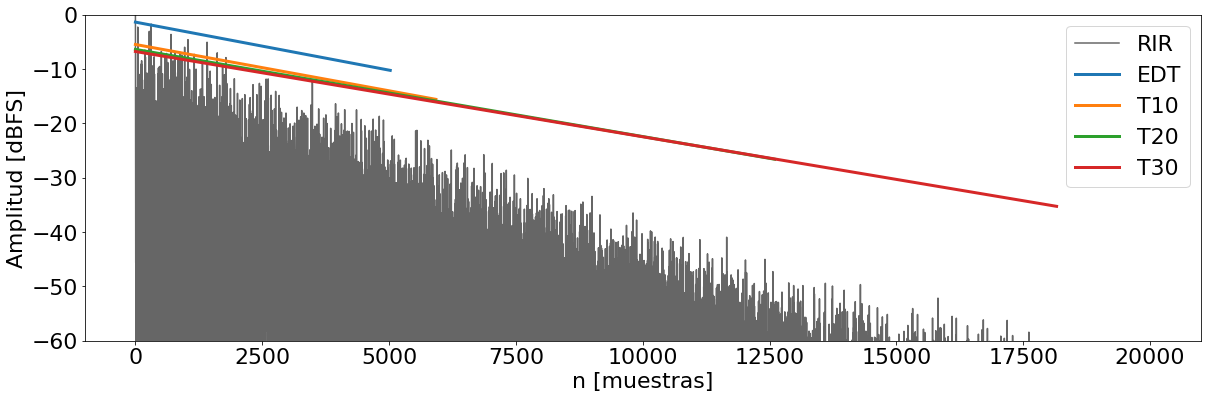

"\nx = np.array([0, 1, 2, 3])\ny = np.array([-1, 0.2, 0.9, 2.1])\n\nA = np.vstack([x, np.ones(len(x))]).T\n\nm, c = np.linalg.lstsq(A, y)[0]\n\nplt.plot(x, y, 'o', label='Original data', markersize=10)\nplt.plot(x, m*x + c, 'r', label='Fitted line')\nplt.legend()\nplt.show()\n"

In [ ]:
import librosa

data, fs = librosa.load('/content/drive/My Drive/Tesis/Base de datos/ejemplo_rir.wav', sr=16000)
TRs, sch, f_edt, c_edt, f_t10, c_t10,  f_t20, c_t20,  f_t30, c_t30 = TR(rir, fs)


plt.figure(facecolor='white', figsize=[20,6], )

plt.ylim(-60, 0)
plt.plot(sch[:20000], label='RIR', color='0.4')

plt.plot(f_edt+c_edt,label='EDT', linewidth=3)
plt.plot(f_t10+c_t10,label='T10', linewidth=3)
plt.plot(f_t20+c_t20, label='T20', linewidth=3)
plt.plot(f_t30+c_t30, label='T30', linewidth=3)

plt.ylabel('Amplitud [dBFS]')
plt.xlabel('n [muestras]')

plt.legend()
plt.show()


"""
x = np.array([0, 1, 2, 3])
y = np.array([-1, 0.2, 0.9, 2.1])

A = np.vstack([x, np.ones(len(x))]).T

m, c = np.linalg.lstsq(A, y)[0]

plt.plot(x, y, 'o', label='Original data', markersize=10)
plt.plot(x, m*x + c, 'r', label='Fitted line')
plt.legend()
plt.show()
"""